# 二分类问题 imdb 电影评论分类

这里使用的是 imdb 电影评论.将评论分为推荐或者不推荐.


## imdb 数据集

imdb 数据集

- 50000 条评论,25000 用于训练,25000 用于验证.
- 为了方便训练,每一个整数代表一个档次,评论被转换成了整数序列.

In [36]:
from keras.datasets import imdb
(train_data, train_labels), (test_data,
                             test_labels) = imdb.load_data(num_words=10000)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\Users\stati\Git\Deep-Learning\tf\lib\site-packages\keras\datasets\imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
c:\Users\stati\Git\Deep-Learning\tf\lib\site-packages\keras\datasets\imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, y

加载 imdb 数据集时,参数 num_words 意味着只取词频前 10000 的单词.其他低频词被忽略.

imdb 数据集原本有 88585 个不同单词,许多词只出现一次,限制单词数量可以降低计算复杂度.


In [37]:
print(train_data[0])
print(train_labels[0])


[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1


train_data test_data 是单词索引组成的列表的列表. train_labels 和 test_labels 代表评论的正面(1)负面(0)


In [38]:
max([max(sequence) for sequence in train_data])

9999

限制了单词字典的总数量,索引索引最大 9999


In [39]:
word_index = imdb.get_word_index()  #将单词映射成整数的字典
reverse_word_index = dict([(value, key) \
        for (key, value) in word_index.items()])  #颠倒 value key
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]])# 解码组合单词\

print(len(word_index))
print(len(reverse_word_index))


88584
88584


这是将评论由整数数组还原成字符串的过程.

decoded_review 时,因为在数据集中 0 1 2 是为了 padding, start of sequence 和 unknow 保留的索引,所以数据集中的单词索引会比映射字典的索引大 3.


## 准备数据

电影评论有长有短,而且神经网络也无法直接处理整数序列.开始训练之前我们要将数据转换成神经网络能接受的输入.

- 既然评论有长有短,干脆都填充到最大长度.之后将列表转换成 (samples, max_length) 形状的整数张量.keras 有专门处理整数张量的层(Embedding 之后会提及)
- 或者换一种,不填充列表,反正单词限定只有 10000 个,使用一个 1d 1000 维的张量,就能表示全部的整数序列.例如整数序列 `[3,5]` 只在 3,5 取 1,其他位置取 0.在书中叫对列表进行 one-hot 编码.


In [40]:
import numpy as np


def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences),dimension))  # 初始化全 0 2d 张量
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1  #sequences 第 i 个整数序列包含的整数值在 results 中的位置设为 1
    return results


x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [41]:
x_train

array([[0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

上面是手动实现的 one-hot 编码.


In [42]:
y_train = np.asarray(train_labels).astype("float32")  # 标签是直接 np 新建张量
y_test = np.asarray(test_labels).astype("float32")

评论和标签都准备完毕.


## 构建模型

输入数据是向量,输出数据是标量.这几乎是深度学习遇到的最简单的问题了.使用 rule 激活函数的 dense layer 的堆叠可以很好的解决这个问题.

dense 层堆叠的模型有两个关键参数

- 模型有几个 dense layer
- 每层各有多少隐藏单元.

第五章会有指导如何选择合适的参数,但是这里暂时直接给出:

- 3 层网络,2 个中间层.第 3 层输出结果.
- 2 个中间层各有 16 个隐藏单元.

![3_layer_network](./3_layer_network.png)


In [43]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),  #16隐藏单元
    layers.Dense(16, activation="relu"),  #16隐藏单元
    layers.Dense(1, activation="sigmoid")
])

前面 2 章的内容,layers.Dense(16, activation="relu") 实际上是做了 `output = relu(dot(input, W) + b)`.

- 与 W 点积是将输入向量投射到 16 维空间,+b 进行偏置,最后进入激活函数,这里是 relu.
- 隐藏单元越多,从数据可能学习到的规律越多,但是计算的代价越大.学习能力过强,可能会挖掘训练集过多特征,但是这些特征在验证集上并没有作用.


激活函数,上面的模型使用了 2 个激活函数,中间层是 relu 输出层是 sigmoid.

- relu(整流线性单元) 旨在将负值归零.![relu](./The-rectified-linear-unit-function.png)
- sigmoid 旨在将任意值压缩到 `[0,1]` 区间.![sigmoid](./The-sigmoid-function.png)


为什么激活函数是必须的?

dense 层只有两个线性运算.+ 和 点积.dense layer 也只能搜索可能的线性组合.这样的假设空间非常受限,即使叠加多层,多层直接依然是线性运算的叠加,假设空间依旧是线性变换的空间.

添加非线性的激活函数,这样多层之间不再是线性运算的叠加,可以大大拓展假设空间.常用的激活函数是 relu 但是还有其他的激活函数可选.上面的 sigmoid elu prelu 等等.


In [44]:
model.compile(
    optimizer='rmsprop',  #优化器
    loss='binary_crossentropy',  #损失函数
    metrics=['accuracy'])  #指标


选定模型的损失函数和优化器.

- 二分类问题,模型输出的是概率.最好的优化器是 binary_crossentropy (二元交叉熵),当然它不是唯一的选择,mean_squared_error(均方误差)也可,但是 binary_crossentropy 对于输出概率的模型往往是更好的选择.
- 优化器则是 rmsprop ,通常适用于大部分问题.
- 指标选择了 accuracy,准确率.


In [45]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

分出 10000 来作为验证集.


In [46]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))


Epoch 1/20
30/30 [==============================] - 1s 26ms/step - loss: 0.5033 - accuracy: 0.7813 - val_loss: 0.3725 - val_accuracy: 0.8684
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2882 - accuracy: 0.9075 - val_loss: 0.3294 - val_accuracy: 0.8627
Epoch 3/20
30/30 [==============================] - 1s 18ms/step - loss: 0.2126 - accuracy: 0.9315 - val_loss: 0.3063 - val_accuracy: 0.8773
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1677 - accuracy: 0.9456 - val_loss: 0.2857 - val_accuracy: 0.8858
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1375 - accuracy: 0.9569 - val_loss: 0.3177 - val_accuracy: 0.8738
Epoch 6/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1154 - accuracy: 0.9645 - val_loss: 0.3039 - val_accuracy: 0.8821
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0955 - accuracy: 0.9716 - val_loss: 0.3128 - val_accuracy: 0.8822
Epoch 8/20
30

这里选择训练 20 轮,每个轮次 batch_size 512..妥妥的过拟合.


In [47]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

在训练集的准确度和损失,在验证集的准确度和损失.


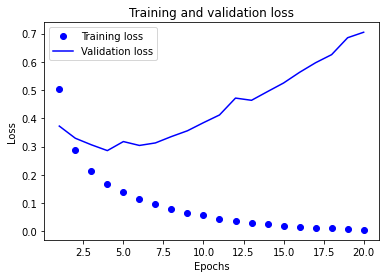

In [48]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

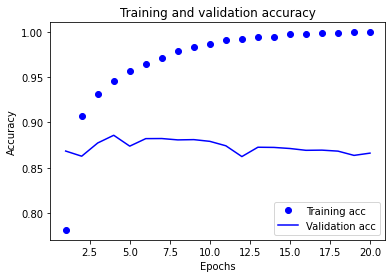

In [49]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

从结果来看,似乎到第 4 轮训练时,模型在验证集上结果做好.过多的轮次带来了越来越严重的过拟合.

第五章会介绍如何减轻过拟合.现在从头训练一个 4 轮次模型.


In [50]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.4806 - accuracy: 0.8163
Epoch 2/4
49/49 [==============================] - 1s 14ms/step - loss: 0.2721 - accuracy: 0.9057
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2058 - accuracy: 0.9260
Epoch 4/4
782/782 [==============================] - 3s 4ms/step - loss: 0.3094 - accuracy: 0.8783


In [51]:
results

[0.30940401554107666, 0.878279983997345]

所以训练 4 轮的模型在验证集的的准确度在 87% 88%,如果使用最先进的方法应该会在 95%.


In [52]:
model.predict(x_test)

array([[0.22634093],
       [0.9999826 ],
       [0.9698435 ],
       ...,
       [0.186115  ],
       [0.1551851 ],
       [0.7488845 ]], dtype=float32)

model.predict 验证结果,验证集的准确度 87%,所以最终测试上模型 0.7 这样的不是那么确定到底是哪一类的评论.


In [65]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 基准
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 28ms/step - loss: 0.4399 - accuracy: 0.8313 - val_loss: 0.3261 - val_accuracy: 0.8841
Epoch 2/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2545 - accuracy: 0.9088 - val_loss: 0.2890 - val_accuracy: 0.8851
Epoch 3/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1962 - accuracy: 0.9307 - val_loss: 0.2840 - val_accuracy: 0.8882
Epoch 4/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1625 - accuracy: 0.9428 - val_loss: 0.3036 - val_accuracy: 0.8830
Epoch 5/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1363 - accuracy: 0.9524 - val_loss: 0.3188 - val_accuracy: 0.8774
Epoch 6/8
49/49 [==============================] - 1s 20ms/step - loss: 0.1166 - accuracy: 0.9603 - val_loss: 0.3443 - val_accuracy: 0.8757
Epoch 7/8
49/49 [==============================] - 1s 20ms/step - loss: 0.1015 - accuracy: 0.9658 - val_loss: 0.3696 - val_accuracy: 0.8715
Epoch 8/8
49/49 [===

到第 3 轮,最好结果是 0.8882 之后过拟合了.

In [66]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 增加一个隐藏层
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 30ms/step - loss: 0.4841 - accuracy: 0.8143 - val_loss: 0.3573 - val_accuracy: 0.8740
Epoch 2/8
49/49 [==============================] - 1s 22ms/step - loss: 0.2683 - accuracy: 0.9082 - val_loss: 0.2878 - val_accuracy: 0.8880
Epoch 3/8
49/49 [==============================] - 1s 22ms/step - loss: 0.2043 - accuracy: 0.9258 - val_loss: 0.2808 - val_accuracy: 0.8885
Epoch 4/8
49/49 [==============================] - 1s 22ms/step - loss: 0.1686 - accuracy: 0.9394 - val_loss: 0.2955 - val_accuracy: 0.8834
Epoch 5/8
49/49 [==============================] - 1s 22ms/step - loss: 0.1467 - accuracy: 0.9468 - val_loss: 0.3143 - val_accuracy: 0.8798
Epoch 6/8
49/49 [==============================] - 1s 22ms/step - loss: 0.1298 - accuracy: 0.9534 - val_loss: 0.3393 - val_accuracy: 0.8755
Epoch 7/8
49/49 [==============================] - 1s 20ms/step - loss: 0.1173 - accuracy: 0.9588 - val_loss: 0.3989 - val_accuracy: 0.8650
Epoch 8/8
49/49 [===

第 3 轮 0.8885 之后过拟合了,貌似第二轮就已经快到临界了.

In [67]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),# 增加隐藏层单元
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 30ms/step - loss: 0.4328 - accuracy: 0.8179 - val_loss: 0.3159 - val_accuracy: 0.8848
Epoch 2/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2436 - accuracy: 0.9120 - val_loss: 0.2997 - val_accuracy: 0.8787
Epoch 3/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1887 - accuracy: 0.9309 - val_loss: 0.2863 - val_accuracy: 0.8867
Epoch 4/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1572 - accuracy: 0.9427 - val_loss: 0.3855 - val_accuracy: 0.8554
Epoch 5/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1318 - accuracy: 0.9536 - val_loss: 0.3619 - val_accuracy: 0.8672
Epoch 6/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1151 - accuracy: 0.9603 - val_loss: 0.3564 - val_accuracy: 0.8744
Epoch 7/8
49/49 [==============================] - 1s 19ms/step - loss: 0.0963 - accuracy: 0.9669 - val_loss: 0.3903 - val_accuracy: 0.8691
Epoch 8/8
49/49 [===

验证集结果来回波动,第一次基本就到头了 0.8848. 是隐藏单元增加假设空间,然后训练的轮次也跟着变少了?

In [68]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),# 增加隐藏层单元
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 28ms/step - loss: 0.4280 - accuracy: 0.8052 - val_loss: 0.3022 - val_accuracy: 0.8839
Epoch 2/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2360 - accuracy: 0.9088 - val_loss: 0.2870 - val_accuracy: 0.8855
Epoch 3/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1821 - accuracy: 0.9310 - val_loss: 0.3016 - val_accuracy: 0.8818
Epoch 4/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1501 - accuracy: 0.9432 - val_loss: 0.3210 - val_accuracy: 0.8773
Epoch 5/8
49/49 [==============================] - 1s 21ms/step - loss: 0.1166 - accuracy: 0.9573 - val_loss: 0.3521 - val_accuracy: 0.8732
Epoch 6/8
49/49 [==============================] - 1s 20ms/step - loss: 0.0923 - accuracy: 0.9657 - val_loss: 0.4519 - val_accuracy: 0.8525
Epoch 7/8
49/49 [==============================] - 1s 20ms/step - loss: 0.0692 - accuracy: 0.9760 - val_loss: 0.4422 - val_accuracy: 0.8676
Epoch 8/8
49/49 [===

基本类似上面情况.

In [69]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 29ms/step - loss: 0.4380 - accuracy: 0.8250 - val_loss: 0.3441 - val_accuracy: 0.8758
Epoch 2/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2697 - accuracy: 0.9098 - val_loss: 0.2919 - val_accuracy: 0.8899
Epoch 3/8
49/49 [==============================] - 1s 19ms/step - loss: 0.2150 - accuracy: 0.9264 - val_loss: 0.2824 - val_accuracy: 0.8880
Epoch 4/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1828 - accuracy: 0.9374 - val_loss: 0.2884 - val_accuracy: 0.8848
Epoch 5/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1613 - accuracy: 0.9463 - val_loss: 0.2895 - val_accuracy: 0.8849
Epoch 6/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1459 - accuracy: 0.9505 - val_loss: 0.2991 - val_accuracy: 0.8818
Epoch 7/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1317 - accuracy: 0.9557 - val_loss: 0.3104 - val_accuracy: 0.8800
Epoch 8/8
49/49 [===

单隐藏层,过拟合后似乎不会衰减那么快.

In [70]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 30ms/step - loss: 0.4187 - accuracy: 0.8369 - val_loss: 0.3248 - val_accuracy: 0.8838
Epoch 2/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2540 - accuracy: 0.9106 - val_loss: 0.2860 - val_accuracy: 0.8878
Epoch 3/8
49/49 [==============================] - 1s 21ms/step - loss: 0.2011 - accuracy: 0.9295 - val_loss: 0.2812 - val_accuracy: 0.8882
Epoch 4/8
49/49 [==============================] - 1s 20ms/step - loss: 0.1699 - accuracy: 0.9407 - val_loss: 0.2866 - val_accuracy: 0.8858
Epoch 5/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1498 - accuracy: 0.9482 - val_loss: 0.3016 - val_accuracy: 0.8803
Epoch 6/8
49/49 [==============================] - 1s 20ms/step - loss: 0.1323 - accuracy: 0.9554 - val_loss: 0.3223 - val_accuracy: 0.8768
Epoch 7/8
49/49 [==============================] - 1s 19ms/step - loss: 0.1193 - accuracy: 0.9601 - val_loss: 0.3338 - val_accuracy: 0.8751
Epoch 8/8
49/49 [===

In [73]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),# 一个隐藏层
    layers.Dense(1, activation="sigmoid")
])
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.fit(x_train, y_train, epochs=8, batch_size=512,validation_data=(x_test, y_test))

Epoch 1/8
49/49 [==============================] - 2s 31ms/step - loss: 0.4146 - accuracy: 0.8316 - val_loss: 0.3195 - val_accuracy: 0.8778
Epoch 2/8
49/49 [==============================] - 1s 22ms/step - loss: 0.2406 - accuracy: 0.9143 - val_loss: 0.2836 - val_accuracy: 0.8885
Epoch 3/8
49/49 [==============================] - 1s 23ms/step - loss: 0.1932 - accuracy: 0.9314 - val_loss: 0.3055 - val_accuracy: 0.8776
Epoch 4/8
49/49 [==============================] - 1s 24ms/step - loss: 0.1623 - accuracy: 0.9422 - val_loss: 0.3058 - val_accuracy: 0.8798
Epoch 5/8
49/49 [==============================] - 1s 23ms/step - loss: 0.1427 - accuracy: 0.9494 - val_loss: 0.3168 - val_accuracy: 0.8775
Epoch 6/8
49/49 [==============================] - 1s 22ms/step - loss: 0.1253 - accuracy: 0.9556 - val_loss: 0.3445 - val_accuracy: 0.8737
Epoch 7/8
49/49 [==============================] - 1s 22ms/step - loss: 0.1137 - accuracy: 0.9604 - val_loss: 0.3557 - val_accuracy: 0.8713
Epoch 8/8
49/49 [===

最终无论如何来回换,测试集的准确度最高都是 88% 偶尔 有 89%,应该是这个问题, dense 堆叠的极限了.


## 结论

带有 relu 激活的 Dense 层堆叠,可以适用于很多问题,但是极限效果还需要换用其他网络架构.

二分类问题的最后一层是使用 sigmoid 激活的 Dense 层,网络输出应该是0~1范围内的标量，表示概率值.

二分类问题的sigmoid标量输出,你应该使用binary_crossentropy损失函数.
